In [195]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, accuracy_score, roc_auc_score


In [7]:

import pandas as pd, yfinance as yf

hsbcdata = (yf.download("HSBA.L", start="2015-01-01", interval="1d", auto_adjust=False)
        .reset_index()
        .rename(columns={"Adj Close":"Adj Close"}))


hsbcdata = hsbcdata[["Date","Open","High","Low","Close","Adj Close","Volume"]].dropna()
hsbcdata = hsbcdata.sort_values("Date").reset_index(drop=True)

hsbcdata.to_csv("HSBA_L_012015_2025.csv", index=False)
print("Saved HSBA_L_012015_2025.csv", hsbcdata.shape, hsbcdata["Date"].min(), "→", hsbcdata["Date"].max())


[*********************100%***********************]  1 of 1 completed

Saved HSBA_L_012015_2025.csv (2730, 7) 2015-01-02 00:00:00 → 2025-10-21 00:00:00


In [9]:
print(hsbcdata.head())


Price        Date        Open        High         Low       Close   Adj Close  \
Ticker                 HSBA.L      HSBA.L      HSBA.L      HSBA.L      HSBA.L   
0      2015-01-02  614.700012  615.213989  607.299988  612.000000  608.370850   
1      2015-01-05  613.700012  615.000000  600.919983  603.900024  600.318970   
2      2015-01-06  604.599976  607.000000  592.289978  593.700012  590.179443   
3      2015-01-07  601.400024  605.099976  583.632996  601.000000  597.436096   
4      2015-01-08  607.000000  609.000000  603.400024  606.200012  602.605408   

Price     Volume  
Ticker    HSBA.L  
0       12528438  
1       32086467  
2       28189734  
3       28395510  
4       21764894  


In [13]:
csv_path = Path("HSBA_L_012015_2025.csv").resolve()

# read
hsbcdata = pd.read_csv("HSBA_L_012015_2025.csv")  

# clean 
hsbcdata["Date"] = pd.to_datetime(hsbcdata["Date"], errors="coerce")
hsbcdata = hsbcdata.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# save to new filename
hsbcdata.to_csv(csv_path, index=False)

In [59]:
print(hsbcdata.head())


In [19]:
# Ensure numeric types (coerce bad strings to NaN, then drop)
for col in ["Open","High","Low","Close","Adj Close","Volume"]:
    if col in hsbcdata.columns:
        hsbcdata[col] = pd.to_numeric(hsbcdata[col], errors="coerce")

hsbcdata = hsbcdata.dropna(subset=["Open","High","Low","Close"]).sort_values("Date").reset_index(drop=True)

In [21]:
# trend: simple moving averages using only past info (shift(1))
hsbcdata["10MA"]  = hsbcdata["Close"].shift(1).rolling(10).mean() 
hsbcdata["50MA"]  = hsbcdata["Close"].shift(1).rolling(50).mean()
hsbcdata["200MA"] = hsbcdata["Close"].shift(1).rolling(200).mean()

In [23]:
# volatility: rolling standard deviation of daily log returns
hsbcdata["log_ret"] = np.log(hsbcdata["Close"] / hsbcdata["Close"].shift(1))
hsbcdata["RSD20"]   = hsbcdata["log_ret"].rolling(20).std()

In [25]:
# range and daily move (informative volatility and momentum proxies)
hsbcdata["H-L"] = hsbcdata["High"] - hsbcdata["Low"]
hsbcdata["O-C"] = hsbcdata["Close"] - hsbcdata["Open"]

In [27]:
# Target 
hsbcdata["Price_increase"] = np.where(hsbcdata["Close"].shift(-1) > hsbcdata["Close"], 1, 0)

In [29]:
#Dropping NA values
hsbcdata = hsbcdata.dropna().reset_index(drop=True)


In [53]:
print(hsbcdata.head())

In [35]:
pd.options.display.float_format = '{:,.3f}'.format   # 3 decimals

In [55]:
# shows count/mean/std/min/percentiles/max for every numeric column
hsbcdata.select_dtypes(include="number").describe().T

In [57]:
print(hsbcdata.dtypes)

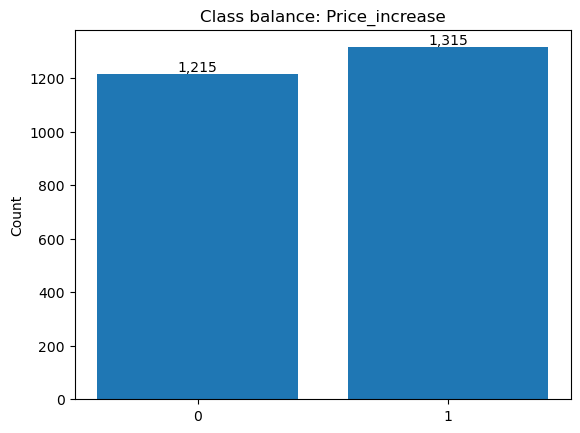

In [69]:

counts = hsbcdata["Price_increase"].value_counts().sort_index()
for x, c in zip([0, 1], counts.values):
    plt.text(x, c, f"{c:,}", ha="center", va="bottom")
plt.bar([0, 1], counts.values)
plt.xticks([0, 1], ["0", "1"])
plt.ylabel("Count")
plt.title("Class balance: Price_increase")
plt.show()


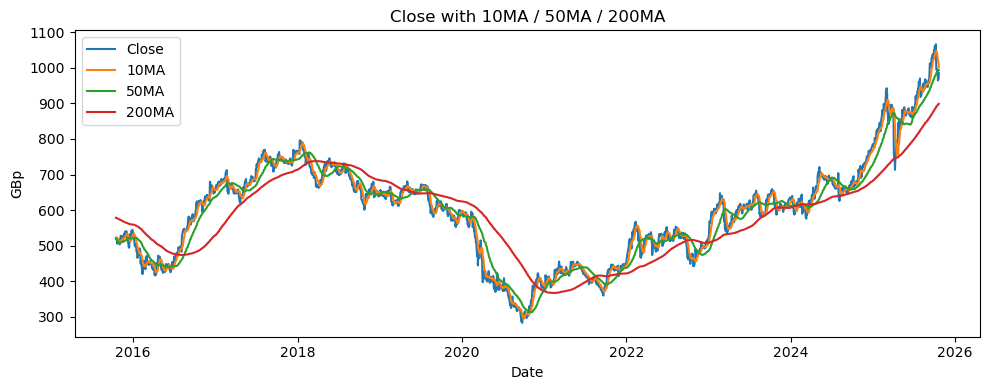

In [73]:
# Close with MAs
plt.figure(figsize=(10,4))
plt.plot(hsbcdata["Date"], hsbcdata["Close"],  label="Close")
plt.plot(hsbcdata["Date"], hsbcdata["10MA"],   label="10MA")
plt.plot(hsbcdata["Date"], hsbcdata["50MA"],   label="50MA")
plt.plot(hsbcdata["Date"], hsbcdata["200MA"],  label="200MA")
plt.title("Close with 10MA / 50MA / 200MA"); plt.legend(); plt.xlabel("Date"); plt.ylabel("GBp")
plt.tight_layout(); plt.show()

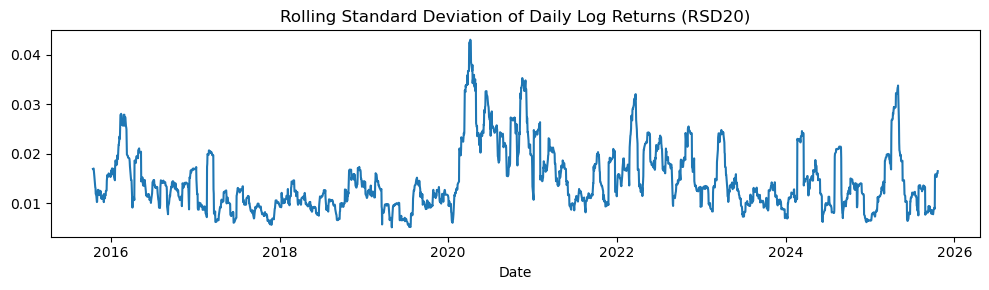

In [77]:
# Rolling volatility
plt.figure(figsize=(10,3))
plt.plot(hsbcdata["Date"], hsbcdata["RSD20"])
plt.title("Rolling Standard Deviation of Daily Log Returns (RSD20)"); plt.xlabel("Date")
plt.tight_layout(); plt.show()


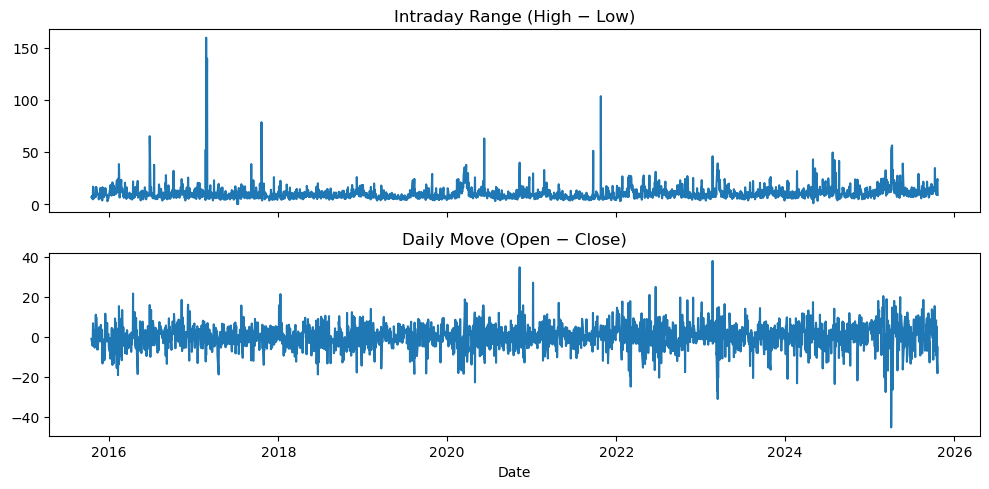

In [81]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
ax[0].plot(hsbcdata["Date"], hsbcdata["H-L"]); ax[0].set_title("Intraday Range (High − Low)")
ax[1].plot(hsbcdata["Date"], hsbcdata["O-C"]); ax[1].set_title("Daily Move (Open − Close)"); ax[1].set_xlabel("Date")
plt.tight_layout(); plt.show()

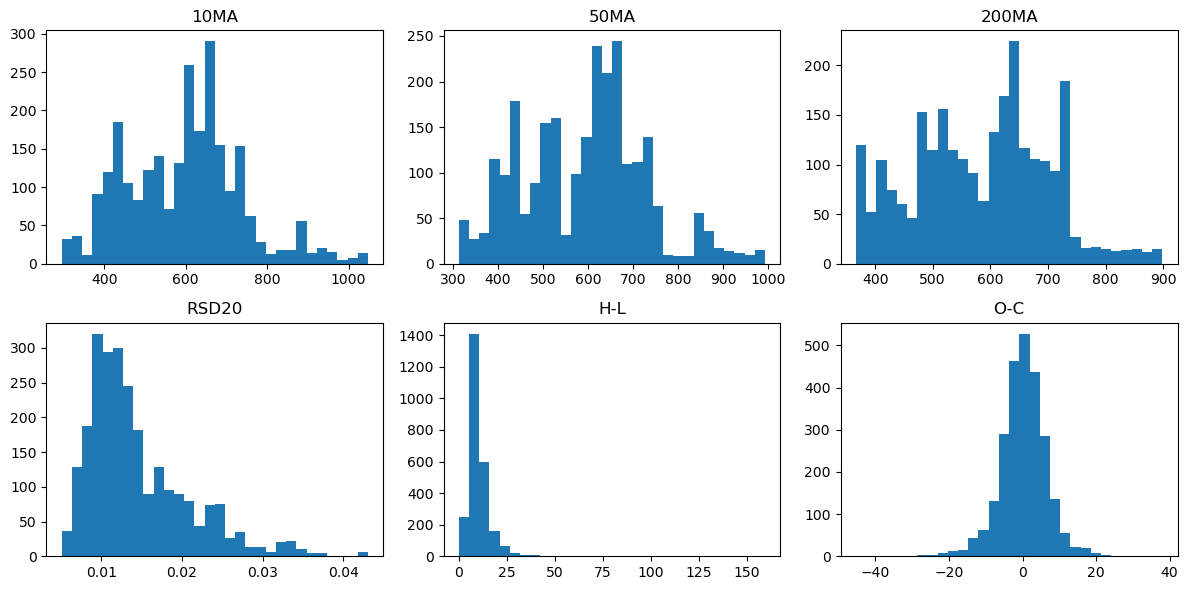

In [101]:
features = ["10MA","50MA","200MA","RSD20","H-L","O-C"]

fig, axes = plt.subplots(2,3, figsize=(12,6))
for ax, col in zip(axes.ravel(), features):
    s = hsbcdata[col].dropna()
    ax.hist(s, bins=30)
    ax.set_title(col)
plt.tight_layout(); plt.show()

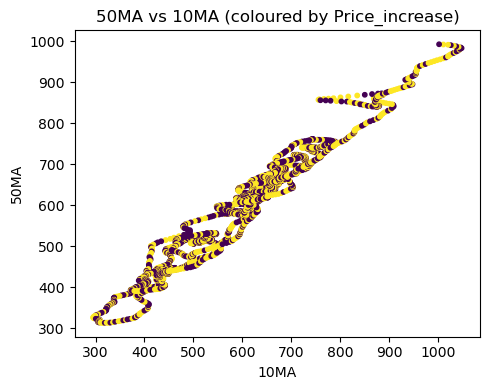

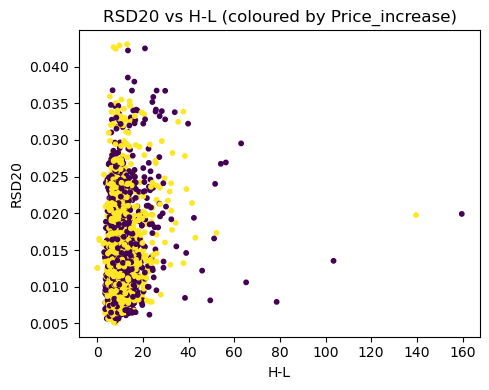

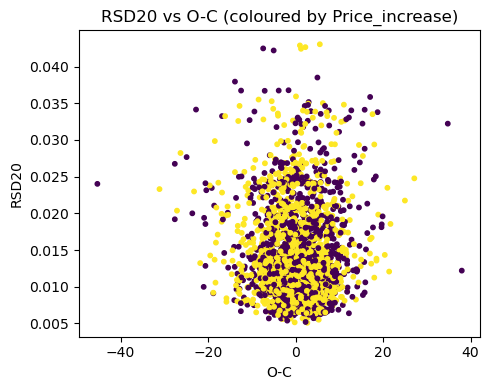

In [109]:
pairs = [("10MA","50MA"), ("H-L","RSD20"), ("O-C","RSD20")]

for x, y in pairs:
    plt.figure(figsize=(5,4))
    plt.scatter(hsbcdata[x], hsbcdata[y], c=hsbcdata["Price_increase"], s=10)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{y} vs {x} (coloured by Price_increase)")
    plt.tight_layout(); plt.show()

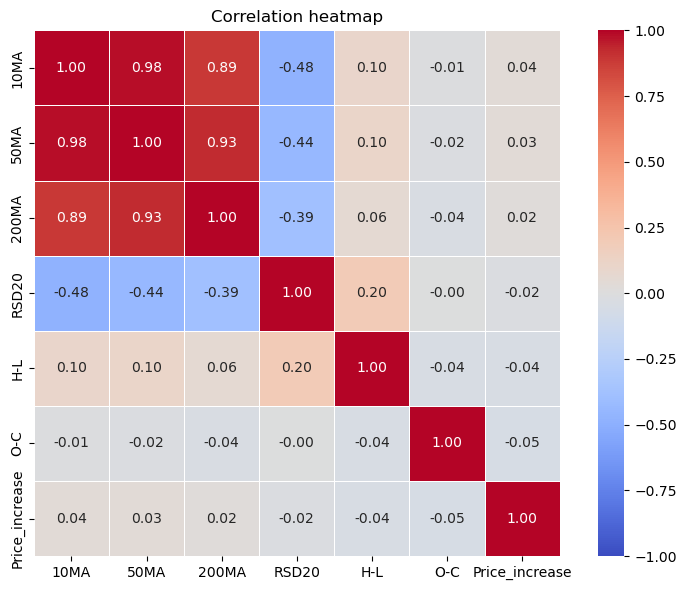

In [135]:
cols = ["10MA","50MA","200MA","RSD20","H-L","O-C","Price_increase"]
corr = hsbcdata[cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=-1, vmax=1,
            linewidths=.5, linecolor="white", square=True)
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()

In [117]:
corr_abs = corr.abs().copy()
np.fill_diagonal(corr_abs.values, 0)
mask = np.triu(np.ones_like(corr_abs.loc[features, features], dtype=bool), 1)
top_ff = corr_abs.loc[features, features].where(mask).stack().sort_values(ascending=False)
print("Top feature–feature correlations:\n", top_ff.head(10).round(3))

Top feature–feature correlations:
 10MA   50MA    0.983
50MA   200MA   0.927
10MA   200MA   0.887
       RSD20   0.482
50MA   RSD20   0.441
200MA  RSD20   0.389
RSD20  H-L     0.197
50MA   H-L     0.102
10MA   H-L     0.100
200MA  H-L     0.057
dtype: float64


In [121]:
ft = corr["Price_increase"].drop("Price_increase").sort_values(key=lambda s: s.abs(), ascending=False)
print("\nFeature–target correlations:\n", ft.round(3))


Feature–target correlations:
 O-C     -0.047
H-L     -0.040
10MA     0.036
50MA     0.032
RSD20   -0.022
200MA    0.020
Name: Price_increase, dtype: float64


In [141]:
# Features and target
feat_cols = ["10MA","50MA","200MA","RSD20","H-L","O-C"]
X = hsbcdata[feat_cols].values
y = hsbcdata["Price_increase"].values

# Hold-out split (preserve time order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale for linear models (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [145]:
logit = LogisticRegression(max_iter=5000, n_jobs=None)     # linear, needs scaling
xtree = ExtraTreesClassifier(n_estimators=300, random_state=0)  # non-linear, no scaling needed

In [169]:
tscv = TimeSeriesSplit(n_splits=5)

logit_cv = cross_val_score(logit, X_train_s, y_train, cv=tscv, scoring="accuracy")
xtree_cv = cross_val_score(xtree, X_train,   y_train, cv=tscv, scoring="accuracy")

print(f"LogisticRegression CV acc: mean={logit_cv.mean():.3f}  sd={logit_cv.std():.3f}")
print(f"ExtraTrees       CV acc: mean={xtree_cv.mean():.3f}  sd={xtree_cv.std():.3f}")

LogisticRegression CV acc: mean=0.520  sd=0.025
ExtraTrees       CV acc: mean=0.496  sd=0.035


In [173]:
# Fit on the training set (scaled), evaluate on the held-out test (scaled)
logit = LogisticRegression(max_iter=5000).fit(X_train_s, y_train)

y_pred  = logit.predict(X_test_s)
y_proba = logit.predict_proba(X_test_s)[:, 1]

print("Test accuracy:", round(accuracy_score(y_test, y_pred), 3),
      "| ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred, digits=3))

Test accuracy: 0.49 | ROC-AUC: 0.547
              precision    recall  f1-score   support

           0      0.428     0.729     0.539       207
           1      0.634     0.324     0.429       299

    accuracy                          0.490       506
   macro avg      0.531     0.527     0.484       506
weighted avg      0.550     0.490     0.474       506



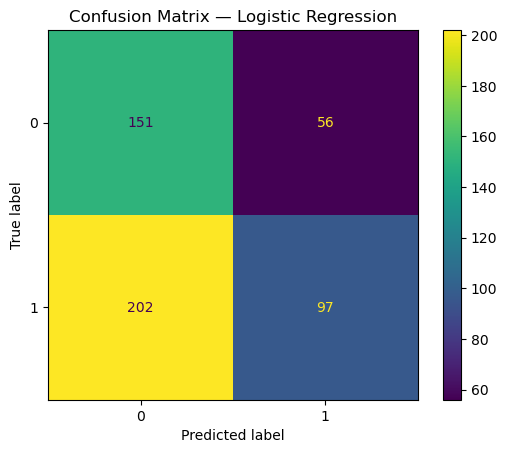

In [179]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(logit, X_test_s, y_test)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

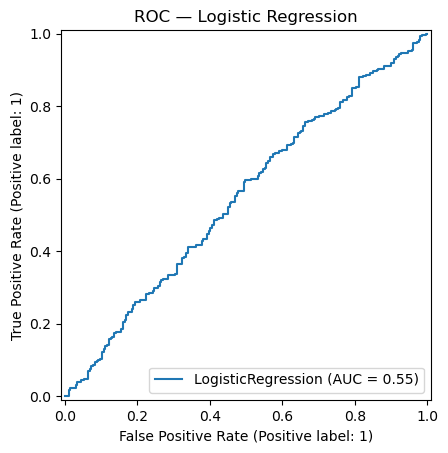

In [183]:
# ROC curve
RocCurveDisplay.from_estimator(logit, X_test_s, y_test)
plt.title("ROC — Logistic Regression")
plt.show()

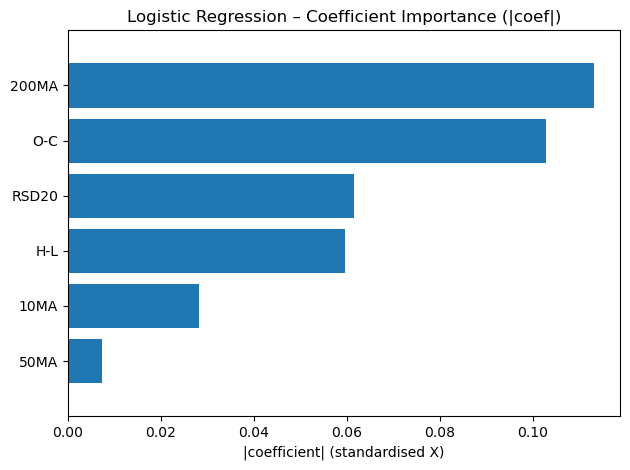

In [187]:
# names (since X is a numpy array)
feature_names = ["10MA","50MA","200MA","RSD20","H-L","O-C"]

# coefficients on standardised X
coef = logit.coef_.ravel()                 # shape (n_features,)
importance = np.abs(coef)                  # magnitude as "importance"
indices = np.argsort(importance)           # ascending, for barh bottom→top
range1 = range(len(indices))

plt.figure()
plt.title("Logistic Regression – Coefficient Importance (|coef|)")
plt.barh(list(range1), importance[indices])
plt.yticks(list(range1), np.array(feature_names)[indices])
plt.ylim(-1, len(range1))
plt.xlabel("|coefficient| (standardised X)")
plt.tight_layout()
plt.show()

In [199]:
# align test slice + predictions
n_train = len(X_train)
test_df = hsbcdata.iloc[n_train:].copy()
test_df["Pred"] = pd.Series(y_pred, index=test_df.index)   # 0/1

In [203]:
# 1) Market return: close-to-close log return
test_df["Market_Return"] = np.log(test_df["Close"] / test_df["Close"].shift(1)).fillna(0.0)

In [207]:
# 2) Strategy return: today’s signal applied to tomorrow’s move (Series-safe)
tom_ret = np.log(test_df["Close"].shift(-1) / test_df["Close"])
test_df["Strategy_Return"] = tom_ret.where(test_df["Pred"] == 1, -tom_ret).fillna(0.0)

In [211]:
# 3) Cumulative (log) returns
test_df["Cum_Market"]   = test_df["Market_Return"].cumsum()
test_df["Cum_Strategy"] = test_df["Strategy_Return"].cumsum()

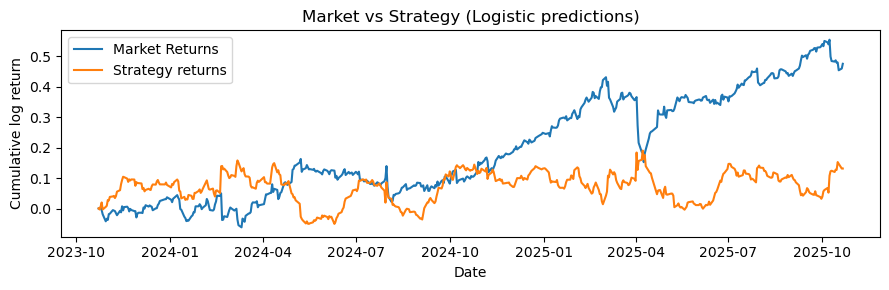

In [215]:
# 4) Plot
plt.figure(figsize=(9,3))
plt.plot(test_df["Date"], test_df["Cum_Market"],   label="Market Returns")
plt.plot(test_df["Date"], test_df["Cum_Strategy"], label="Strategy returns")
plt.ylabel("Cumulative log return"); plt.xlabel("Date"); plt.legend()
plt.title("Market vs Strategy (Logistic predictions)")
plt.tight_layout(); plt.show()